# IMPORTS

In [9]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
import numpy as np
import pandas as pd

# RDKIT FUNCTIONS

## Circular Fingerprints

### Example

Indices of set bits: [17, 53, 55, 60, 76, 85, 91, 101, 109, 122]


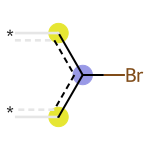

In [14]:
# Example SMILES
smiles = "BrC1=CC=CC=C1"  

# Create an RDKit molecule object from SMILES
mol = Chem.MolFromSmiles(smiles)

# Generate Morgan fingerprints for the substructure
radius = 2  # adjust the radius as needed
bit = {}
fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=124, bitInfo=bit)

# Print the indices of the set bits in the Morgan fingerprint
set_bits_indices = list(np.nonzero(np.array(fingerprint))[0])
print("Indices of set bits:", set_bits_indices)

Draw.DrawMorganBit(mol,17, bit)

### FUNCTION

In [15]:
def compute_fingerprints(df, smiles_column='smiles', fp_type='morgan', radius=2, fpSize=1024):
    """
    Compute fingerprints for each SMILES in a DataFrame and add the fingerprint bits as separate columns.

    Parameters:
    - df (pd.DataFrame): DataFrame containing SMILES.
    - smiles_column (str): Name of the column containing SMILES.
    - fp_type (str): Type of fingerprint ('morgan', 'rdkit', 'torsional', 'atom_pair').
    - radius (int): Radius parameter for Morgan fingerprints.
    - n_bits (int): Number of bits in the fingerprint.

    Returns:
    - pd.DataFrame: DataFrame with added fingerprint bit columns.
    """

    # Initialize a list to store fingerprint bits
    fingerprint_bits_list = []

    # Define fingerprint calculation method based on fp_type
    if fp_type == 'morgan':
        fingerprint_function = lambda mol: AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=fpSize)
    elif fp_type == 'rdkit':
        fingerprint_function = lambda mol: AllChem.PatternFingerprint(mol, fpSize=fpSize)
    elif fp_type == 'torsional':
        fingerprint_function = lambda mol: AllChem.GetHashedTopologicalTorsionFingerprintAsBitVect(mol, nBits=fpSize)
    elif fp_type == 'atom_pair':
        fingerprint_function = lambda mol: AllChem.GetHashedAtomPairFingerprintAsBitVect(mol, nBits=fpSize)
    else:
        raise ValueError("Invalid fingerprint type. Supported types are 'morgan', 'rdkit', 'torsional', 'atom_pair'.")

    # Compute fingerprints for each SMILES
    for smiles in df[smiles_column]:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            # Compute fingerprint bits
            fingerprint_bits_list.append(list(map(int, fingerprint_function(mol).ToBitString())))
        else:
            # If SMILES cannot be converted to a valid molecule, append a list of Nones
            fingerprint_bits_list.append([None] * fpSize)

    # Create column names for fingerprint bits
    column_names = [f'bit_{i+1}' for i in range(fpSize)]

    # Concatenate the fingerprint bits as new columns to the DataFrame
    df = pd.concat([df, pd.DataFrame(fingerprint_bits_list, columns=column_names)], axis=1)

    return df

In [16]:
data = {'smiles': ['CCO', 'CCN', 'CCOCC']}
dataframe = pd.DataFrame(data)

# Example usage for Morgan fingerprints
df_morgan = compute_fingerprints(dataframe, fp_type='morgan', radius=2, fpSize=1024)
# display(df_morgan)

# Example usage for RDKit fingerprints
df_rdkit = compute_fingerprints(dataframe, fp_type='rdkit', fpSize=128)
# display(df_rdkit)

# Example usage for RDKit torsional fingerprints
df_torsional = compute_fingerprints(dataframe, fp_type='torsional', fpSize=512)
# display(df_torsional)

# Example usage for RDKit atom pair fingerprints
df_atom_pair = compute_fingerprints(dataframe, fp_type='atom_pair', fpSize=512)
display(df_atom_pair)

,smiles,bit_1,bit_2,bit_3,bit_4,bit_5,bit_6,bit_7,bit_8,bit_9,...,bit_503,bit_504,bit_505,bit_506,bit_507,bit_508,bit_509,bit_510,bit_511,bit_512
0,CCO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CCN,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,CCOCC,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
